In [1]:
from sklearn.datasets import fetch_openml
mnist =fetch_openml('mnist_784', as_frame=False)

KeyboardInterrupt: 

3


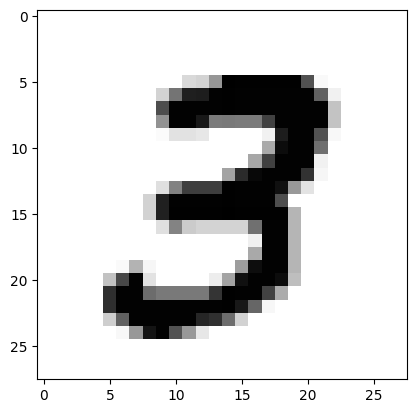

In [35]:
import matplotlib.pyplot as plt
index = 7
target = mnist.target[index]
print(target)
img = mnist.data[index].reshape(28,28)
plt.imshow(img, cmap = 'binary')
plt.show()

In [6]:
X,y = mnist.data, mnist.target

In [37]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [38]:
y

array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [23]:
y_train_1 = (y_train == '1')

In [2]:
X_train

NameError: name 'X_train' is not defined

In [24]:
y_test_1 = (y_test == '1')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score

hyper_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

log_reg = LogisticRegression(C=0.01, penalty='l1', solver='liblinear', verbose=1)

grid = GridSearchCV(log_reg, param_grid=hyper_params, scoring='accuracy', verbose=1, cv=3)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\79639\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[LibLinear]

c:\Users\79639\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[LibLinear]

c:\Users\79639\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[LibLinear]

c:\Users\79639\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[LibLinear]

In [25]:
from sklearn.linear_model import SGDClassifier

In [26]:
sgd_clf = SGDClassifier(
    random_state=42,       # For reproducibility of results.
    class_weight='balanced', # Automatically adjusts weights inversely proportional to class frequencies.
    loss='log_loss'        # Use 'log_loss' for logistic regression style classification
                           # or 'hinge' for linear SVM. 'log_loss' is generally good.
)
sgd_clf.fit(X_train, y_train_1)

,loss,'log_loss'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [27]:
#print the accuracies 
print("Training Accuracy: ", sgd_clf.score(X_train, y_train_1))
print("Testing Accuracy: ", sgd_clf.score(X_test, y_test_1))

Training Accuracy:  0.9551
Testing Accuracy:  0.9607


In [28]:
import numpy as np

In [29]:
from PIL import Image # Required for image processing

In [31]:
def predict(img_input):
    """
    Predicts if the drawn image is a '1' or not using the trained SGDClassifier.

    Args:
        img_input (dict): The input from Gradio's ImageEditor component.
                          It contains the image data under the 'background' key.
                          Example: {'background': array([...], shape=(800, 800, 4), dtype=uint8)}
    Returns:
        int: 1 if the model predicts the digit is '1', 0 if it predicts 'not 1'.
             Returns a string message if the input is invalid or empty.
    """
    # Basic input validation: Check if an image was actually drawn/provided.
    if img_input is None or 'background' not in img_input or img_input['background'] is None:
        return "Please draw a digit on the canvas."

    # Extract the raw image data (NumPy array) from the 'background' key.
    img_array = img_input['background']

    # Ensure the extracted data is indeed a NumPy array.
    if not isinstance(img_array, np.ndarray):
        return "Error: Image background is not a NumPy array. Unexpected input format."

    # Convert the NumPy array (which is likely RGBA - Red, Green, Blue, Alpha channels)
    # into a PIL (Pillow) Image object. This is useful for image manipulations.
    # We cast to uint8 to ensure compatibility with PIL.
    pil_image = Image.fromarray(img_array.astype(np.uint8))

    # Convert the image to grayscale ('L' mode in PIL) and resize it to 28x28 pixels.
    # MNIST images are 28x28 grayscale, so this step is critical for matching the model's input expectation.
    img_processed = pil_image.convert('L') # 'L' mode means 8-bit pixels, black and white.
    img_processed = img_processed.resize((28, 28)) # Resize to the target dimensions.

    # Convert the processed PIL Image back into a NumPy array.
    img_processed = np.array(img_processed)

    # --- CRUCIAL FIX: Invert colors if the background is white ---
    # The SGDClassifier was trained on MNIST, where digits are white on a black background.
    # If the user draws on a white background (common in drawing apps), the digit will be black.
    # We check the top-left pixel (assumed to be background). If it's bright (e.g., > 128),
    # it means the background is white, and we need to invert the image.
    if img_processed[0, 0] > 128: # A threshold of 128 (mid-gray) is used to detect bright background.
        img_processed = 255 - img_processed # Invert pixel values (0 becomes 255, 255 becomes 0).

    # Normalize pixel values: scale them from 0-255 to 0.0-1.0.
    # This is a standard preprocessing step for neural networks.
    # Reshape the 28x28 image into a 1x784 (flattened) array, as expected by the SGDClassifier.
    img_final = img_processed.reshape(1, 784) / 255.0

    # Make a prediction using the trained SGDClassifier.
    # .predict() returns an array, so [0] extracts the single prediction.
    prediction = sgd_clf.predict(img_final)[0]

    # Return the prediction as an integer (1 or 0).
    return int(prediction)

In [32]:
import gradio as gr

In [33]:
gr.Interface(
    fn=predict, # The function to call when the user submits an image.
    inputs=gr.ImageEditor( # The input component, allowing users to draw.
        type="numpy",      # Specifies that the image data should be passed as a NumPy array (within a dict).
        image_mode="L",    # Sets the image editor to grayscale mode, matching MNIST.
        width=280,         # Display width of the drawing canvas.
        height=280,        # Display height of the drawing canvas.
        label="Draw a digit (0-9)" # Label displayed above the drawing area.
    ),
    outputs=gr.Label(label="Prediction (1 if '1', 0 if 'not 1')"), # The output component to display the prediction.
    title="MNIST Digit Recognizer (SGDClassifier - Is it a '1'?)", # Title of the Gradio app.
    description="Draw a single digit (0-9) on the canvas. The model will predict '1' if it thinks it's the digit '1', and '0' otherwise." # Description for the app.
).launch(share=True) # Starts the Gradio interface.


* Running on local URL:  http://127.0.0.1:7865

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
